# *SYNtzulu* Hardware File Generator, Software vs Simulation/Hardware Verification
Please specify below the new application name and the network object file

In [1]:
application = 'emg'
object_name = 'continuous_sEMG_classification.obj'

# DATA LOADING

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt

In [3]:
class Deployment:

    layers = 4
    fs = 0
    data_width_in_byte = 0
    classifier = 0
    window_in_seconds = 0
    classification_stride_in_seconds = 0
    encoding = "spike_detection"
    delta = 0.0

    def __init__(self,input_encoding,input_network,n1,n2,n3,n4,N):
      self.input_encoding = input_encoding
      self.input_network = input_network
      self.n1 = n1
      self.n2 = n2
      self.n3 = n3
      self.n4 = n4
      self.N  = N

    def set_weights(self,w1,w2,w3,w4):
      self.set_weights_helper(w1,1,self.input_network,self.n1)
      self.set_weights_helper(w2,2,self.n1,self.n2)
      self.set_weights_helper(w3,3,self.n2,self.n3)
      self.set_weights_helper(w4,4,self.n3,self.n4)

    def set_weights_helper(self,w,i,d1,d2):
      if not torch.is_tensor(w):
            raise TypeError("weight_" + str(i) + " must be a numpy")
      dim = w.shape
      if not dim == (d2,d1):
            raise TypeError('weight_' + str(i) + ' must be ' + str((d2,d1)) + ' but is ' + str(dim))
      if i==1:
       self.weights_1 = w
      elif i==2:
        self.weights_2 = w
      elif i==3:
        self.weights_3 = w
      elif i==4:
        self.weights_4 = w

    def set_current_decay(self,idecay):
      if not torch.is_tensor(idecay):
            raise TypeError("current_decay must be torch")
      dim = idecay.shape
      if not dim[0] == self.layers:
            raise TypeError('Current_decay must contain 4 elements')
      self.current_decay = idecay

    def set_voltage_decay(self,vdecay):
      if not torch.is_tensor(vdecay):
            raise TypeError("voltage_decay must be torch")
      dim = vdecay.shape
      if not dim[0] == self.layers:
            raise TypeError('Voltage_decay must contain 4 elements')
      self.voltage_decay = vdecay

    def set_threshold(self,threshold):
      if not torch.is_tensor(threshold):
            raise TypeError("threshold must be torch")
      dim = threshold.shape
      if not dim[0] == self.layers:
            raise TypeError('Threshold must contain 4 elements')
      self.threshold = threshold

    def set_scale(self,scale):
      if not torch.is_tensor(scale):
            raise TypeError("scale must be torch")
      dim = scale.shape
      if not dim[0] == self.layers:
            raise TypeError('Scale must contain 4 elements')
      self.scale = scale

    def set_delay_support(self,d,n,i):
      if not torch.is_tensor(d):
            raise TypeError("Delay_" + str(i) + " must be torch")
      dim = d.shape
      if not dim[0] == n:
            raise TypeError("Delay_" + str(i) +  " must contain " + str(n) + " elements")
      if torch.is_floating_point(d):
            raise TypeError("Delay_" + str(i) +  " must be dtype=torch.int32")
      if i==1:
       self.delay_1 = d
      elif i==2:
        self.delay_2 = d
      elif i==3:
        self.delay_3 = d
      elif i==4:
        self.delay_4 = d

    def set_delay(self,d1,d2,d3,d4):
      self.set_delay_support(d1,self.n1,1)
      self.set_delay_support(d2,self.n2,2)
      self.set_delay_support(d3,self.n3,3)
      self.set_delay_support(d4,self.n4,4)

    def set_input_encoding(self,vector):
      if not torch.is_tensor(vector):
            raise TypeError("Test_vector must be torch")
      dim = vector.shape
      if not dim == (self.input_encoding,self.N):
            raise TypeError('Input encoding must be torch ' + str((self.input_encoding,self.N)) + ' but is ' + str(dim))
      self.test_vector_encoding = vector

    def set_input_network(self,vector):
      if not torch.is_tensor(vector):
            raise TypeError("Test_vector must be torch")
      dim = vector.shape
      if not dim == (self.input_network,self.N):
            raise TypeError('input network must be torch ' + str((self.input_network,self.N)) + ' but is ' + str(dim))
      self.test_vector_snn = vector

    def set_output(self,vector):
      if not torch.is_tensor(vector):
            raise TypeError("Target_vector must be torch")
      dim = vector.shape
      if not dim == (self.n4,self.N):
            raise TypeError('Target_vector must be torch ' + str((self.n4,self.N)) + ' but is ' + str(dim))
      self.target_vector = vector

In [4]:
# load object
import pickle

file = open(object_name, 'rb')
deploy = pickle.load(file)
file.close()

In [5]:
# setup notebook variables

weights_1 = deploy.weights_1
weights_2 = deploy.weights_2
weights_3 = deploy.weights_3
weights_4 = deploy.weights_4
current_decay = deploy.current_decay
voltage_decay = deploy.voltage_decay
threshold = deploy.threshold
s_scale = deploy.scale
delay_1 = deploy.delay_1
delay_2 = deploy.delay_2
delay_3 = deploy.delay_3
delay_4 = deploy.delay_4
#bin2 =  deploy.test_vector
test_vector_snn = deploy.test_vector_snn
test_vector_encoding = deploy.test_vector_encoding
inference = deploy.target_vector
layers = deploy.layers
delta = deploy.delta

# Ground Truth Computation for Simulation/Hardware Comparison

In [37]:
#@title NEURON COMPUTATION MODEL DEFINITION

import torch

def right_shift(x,bits):
    x_sign = 2 * ( x > 0 ) - 1
    return (x_sign * ((x_sign * x) >> bits))

def quantize(input_value, step = 1):
    return torch.round(input_value / step) * step

def integrate (stimolo, decay, state, scale, threshold = None):

    output_old = (state*scale).to(torch.int64)
    scale_l2 = int(np.log2(scale))
    decay_int = 4096 - decay.to(torch.int64)
    output_new = torch.zeros_like(stimolo).to(torch.int64)
    spikes_new = torch.zeros_like(stimolo).to(torch.int64)

    output_old_array = torch.zeros_like(stimolo)
    output_old_array[0,:] = output_old

    if threshold is None:
        threshold_int = None
    else:
        threshold_int = threshold

    for i in range(stimolo.shape[0]):

        output_new[i,:] = right_shift((output_old*decay_int).to(torch.int64),12) + (stimolo[i,:]).to(torch.int64)

        if threshold_int is not None:
            if threshold_int > 0:
                spikes_new[i,:] = output_new[i,:] >= threshold_int

                output_old = output_new[i,:]
                output_old[output_old >= threshold_int] = 0
            else:
                output_old = output_new[i,:]
        else:
            output_old = output_new[i,:]

        if i < stimolo.shape[0]-1:
            output_old_array[i+1,:] = output_old.to(torch.float64)

    return ((output_new).numpy(), spikes_new, output_old_array)


def spike_detection(voltage,threshold):
    return (voltage >= threshold).to(torch.int32)


def axonal_delay_function(spike,delay):

  delayed_spike = np.zeros_like(spike);
  for i in range(spike.shape[1]):
    last_element = spike.shape[0] - delay[i]
    delayed_spike[delay[i]:,i] = spike[0:last_element,i]
  return delayed_spike

In [38]:
#@title NETWORK EVALUATION

input_vector = test_vector_snn

stimolo_1 = np.matmul(input_vector.transpose(1,0), (weights_1.squeeze()*s_scale[0]).round().transpose(1,0))
#stimolo_1, _, current_old_1 = integrate(torch.tensor(stimolo_1), quantize(current_decay[0]), torch.tensor(0.0), s_scale[0], None) # if enabled LIF become CUBA neuron
voltage_1, spike_1, voltage_old_1 = integrate(torch.tensor(stimolo_1), quantize(voltage_decay[0]), torch.tensor(0.0), s_scale[0], (threshold[0]*s_scale[0]).round())
dummy = torch.zeros_like(spike_1)
dummy[1:,:] = spike_1[0:-1,:]
spike_1 = axonal_delay_function(dummy,delay_1)

stimolo_2 = np.matmul(spike_1, (weights_2.squeeze()*s_scale[1]).round().transpose(1,0))
#stimolo_2, _, current_old_2 = integrate(torch.tensor(stimolo_2), quantize(current_decay[1]), torch.tensor(0.0), s_scale[1], None) # if enabled LIF become CUBA neuron
voltage_2, spike_2, voltage_old_2 = integrate(torch.tensor(stimolo_2), quantize(voltage_decay[1]), torch.tensor(0.0), s_scale[1], (threshold[1]*s_scale[1]).round())
dummy = torch.zeros_like(spike_2)
dummy[1:,:] = spike_2[0:-1,:]
spike_2 = axonal_delay_function(dummy,delay_2)

stimolo_3 = np.matmul(spike_2, (weights_3.squeeze()*s_scale[2]).round().transpose(1,0))
#stimolo_3, _, current_old_3 = integrate(torch.tensor(stimolo_3), quantize(current_decay[2]), torch.tensor(0.0), s_scale[2], None) # if enabled LIF become CUBA neuron
voltage_3, spike_3, voltage_old_3 = integrate(torch.tensor(stimolo_3), quantize(voltage_decay[2]), torch.tensor(0.0), s_scale[2], (threshold[2]*s_scale[2]).round())
dummy = torch.zeros_like(spike_3)
dummy[1:,:] = spike_3[0:-1,:]
spike_3 = axonal_delay_function(dummy,delay_3)

stimolo_4 = np.matmul(spike_3, (weights_4.squeeze()*s_scale[3]).round().transpose(1,0))
#stimolo_4, _, current_old_4 = integrate(torch.tensor(stimolo_4), quantize(current_decay[3]), torch.tensor(0.0), s_scale[3], None) # if enabled LIF become CUBA neuron
voltage_4, spike_4, voltage_old_4 = integrate(torch.tensor(stimolo_4), quantize(voltage_decay[3]), torch.tensor(0.0), s_scale[3], (threshold[3]*s_scale[3]).round())
dummy = torch.zeros_like(spike_4)
dummy[1:,:] = spike_4[0:-1,:]
spike_4 = dummy

<ipython-input-38-04f189d956fc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voltage_1, spike_1, voltage_old_1 = integrate(torch.tensor(stimolo_1), quantize(voltage_decay[0]), torch.tensor(0.0), s_scale[0], (threshold[0]*s_scale[0]).round())
<ipython-input-38-04f189d956fc>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voltage_2, spike_2, voltage_old_2 = integrate(torch.tensor(stimolo_2), quantize(voltage_decay[1]), torch.tensor(0.0), s_scale[1], (threshold[1]*s_scale[1]).round())
<ipython-input-38-04f189d956fc>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

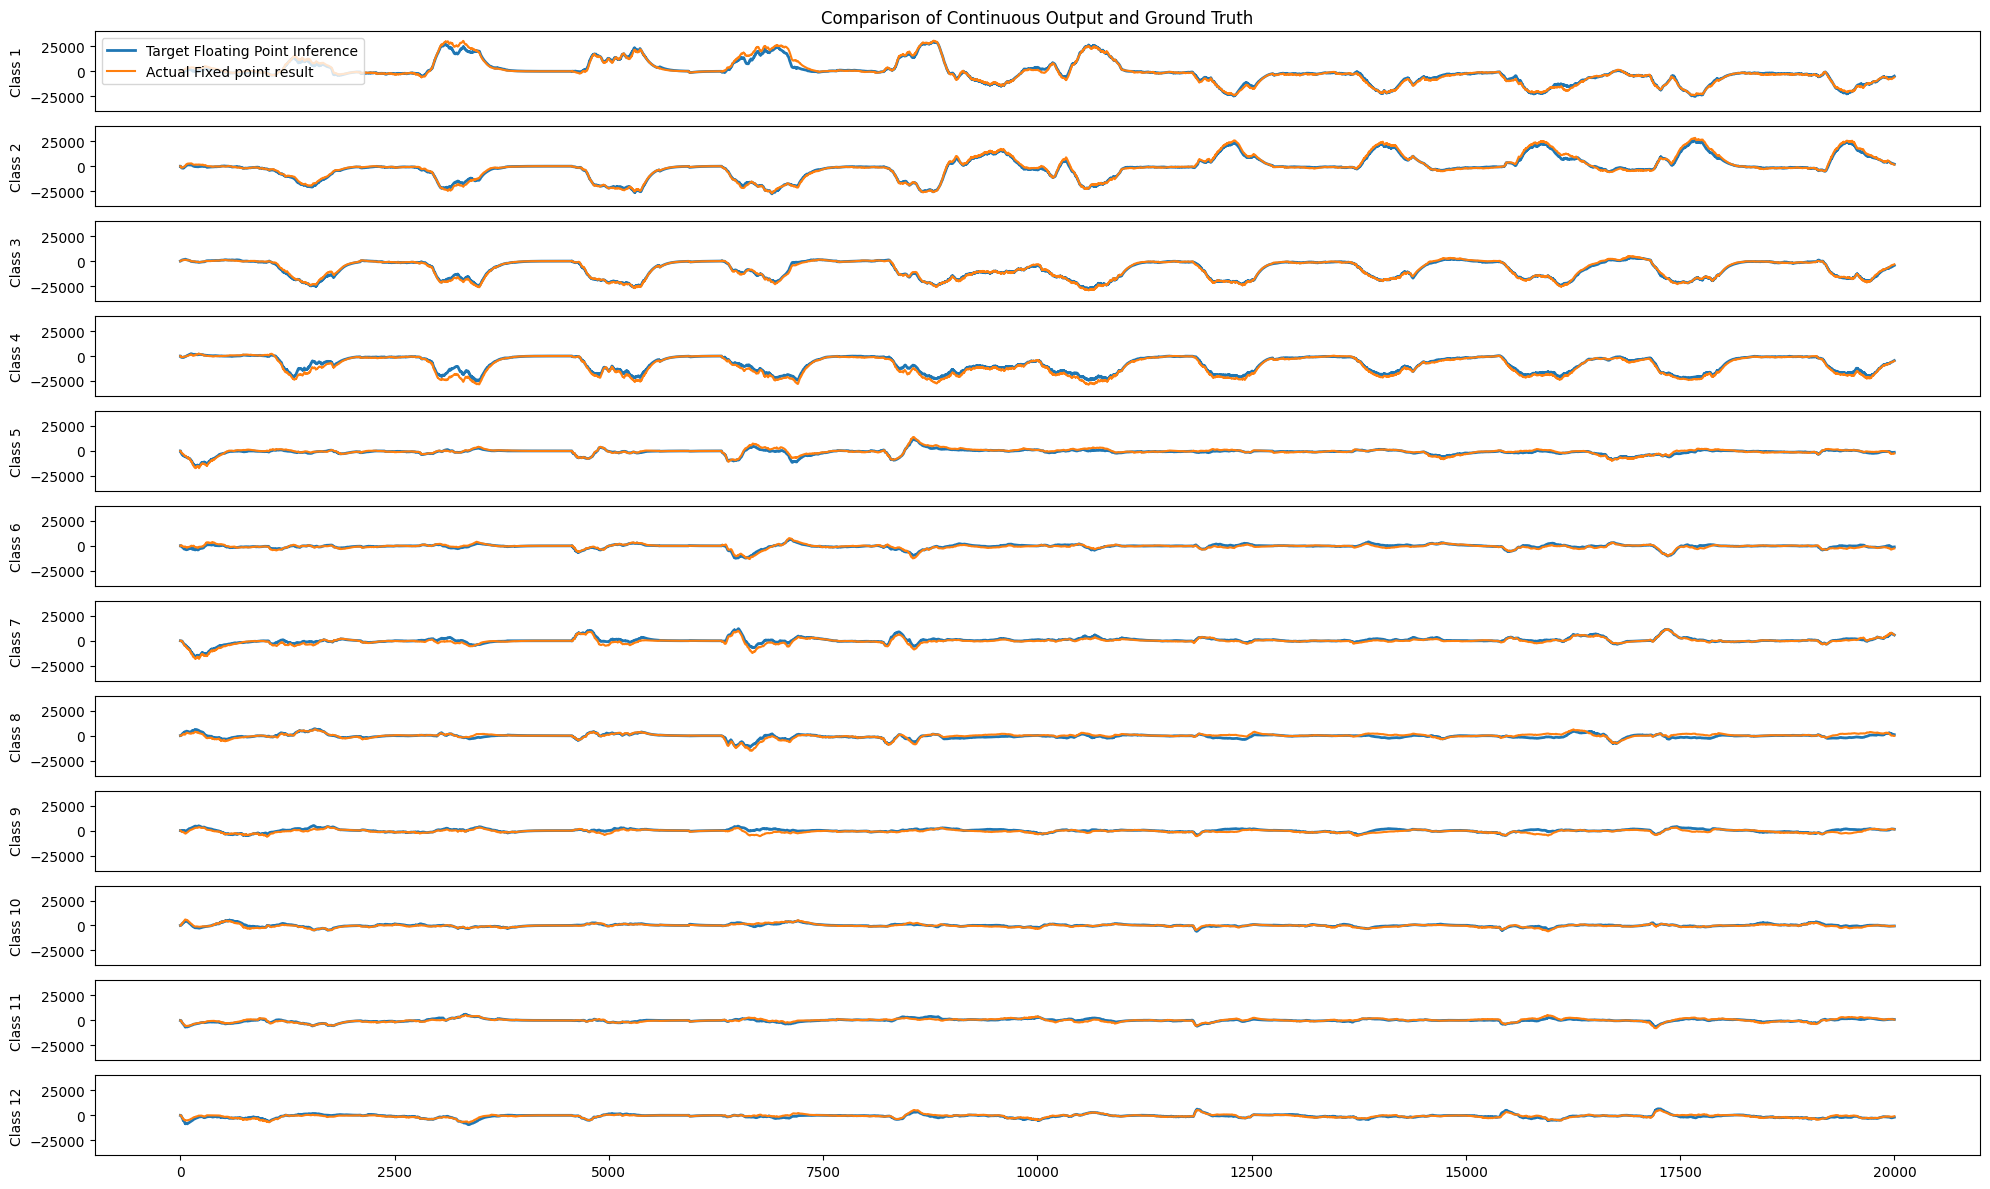

In [39]:
#@title Plot Continuous Output
import matplotlib.pyplot as plt

t = range(20000)

fig, axs = plt.subplots(12, 1, figsize=(20, 12))  # 12 rows for subplots

for i in range(12):
  axs[i].plot(inference[i,t]*s_scale[3],linewidth=2, label='Target Floating Point Inference')
  axs[i].plot(voltage_4[t,i], label='Actual Fixed point result')
  axs[i].set_ylabel(f'Class {i + 1}')

  if i < 11:
    axs[i].set_xticks([])  # Hide xticks for all subplots except the last one
  axs[i].set_ylim(-40000, 40000)

axs[0].legend(loc='upper left')
axs[0].set_title('Comparison of Continuous Output and Ground Truth')
plt.tight_layout()
plt.show()

# Simulation Files Generation

In [40]:
#@title SUPPORT FUNCTIONS

def hex_conv(num, bits):
    if num < 0:
        sign_extension = (1 << bits) - 1  # Calcola il valore dell'estensione del segno
        num = num & sign_extension  # Applica l'estensione del segno
        hex_num = hex(num)[2:]
    else:
        binary = bin(num)[2:]  # Converte il numero in rappresentazione binaria e rimuove il prefisso "0b"
        if len(binary) < bits:
          zero_extension = "0" * int((bits - len(binary))/4)  # Genera la stringa di zeri da aggiungere
          hex_num = zero_extension + hex(num)[2:] # Aggiunge gli zeri all'inizio
        else:
          hex_num = hex(num)[2:]
    return hex_num

def is_power_of_two(n):
    # Check if n is greater than 0 and if n & (n - 1) equals 0
    return n > 0 and (n & (n - 1)) == 0

def next_power_of_two(n):
    # Start with the smallest power of two, 1, and keep doubling until it's greater than n
    power = 1
    while power <= n:
        power *= 2
    return power

In [41]:
#@title HEXADECIMAL WEIGHT FILE FOR TOP SIMULATION OF SYNtzulu

import os
for i in range(layers):
  if os.path.exists("weights_1.txt"):
      os.remove("weights_1.txt")
      os.remove("weights_2.txt")
      os.remove("weights_3.txt")
      os.remove("weights_4.txt")

weights = [weights_1,weights_2,weights_3,weights_4]
files = ['weights_1.txt','weights_2.txt','weights_3.txt','weights_4.txt']

with open(files[0],'a') as fa , open(files[1],'a') as fb, open(files[2],'a') as fc , open(files[3],'a') as fd :
  for k in range(layers): # for each layer
      weights_int = (weights[k].squeeze()*s_scale[k]).round().to(torch.int32);

      for j in range(weights_int.shape[0]): # for each neuron
          weigths_a_hex = []
          weigths_b_hex = []
          for i in range(0,weights_int.shape[1],4): # for each group of four synapses
              w1 = hex_conv(weights_int[j,i],8)
              w2 = hex_conv(weights_int[j,i+1],8)
              w3 = hex_conv(weights_int[j,i+2],8)
              w4 = hex_conv(weights_int[j,i+3],8)
              w_a_hex = w1+' '+w2
              w_b_hex = w3+' '+w4
              weigths_a_hex.append( w_a_hex )
              weigths_b_hex.append( w_b_hex )

          line_a = ' '.join(weigths_a_hex)
          line_b = ' '.join(weigths_b_hex)

          # synaptic weights padding to power of 2
          if (is_power_of_two(weights_int.shape[1])):
            padding = 0
          else:
            padding = int((next_power_of_two(weights_int.shape[1]) - weights_int.shape[1])/4)
          if(j%2): # 2nd core
            fc.write(line_a + ' ' + ('00 00' + ' ')*padding + '\n')
            fd.write(line_b + ' ' + ('00 00' + ' ')*padding + '\n')
          else:  # 1st core
            fa.write(line_a + ' ' + ('00 00' + ' ')*padding + '\n')
            fb.write(line_b + ' ' + ('00 00' + ' ')*padding + '\n')

      # neuron padding to power of two
      if (is_power_of_two(weights_int.shape[0])):
        padding2 = 0
      else:
        padding2 = (next_power_of_two(weights_int.shape[0]) - weights_int.shape[0])
      int_padd = np.floor_divide(padding2,2)
      remainder = np.remainder(padding2,2)
      if (is_power_of_two(weights_int.shape[1])):
        synapses = int(weights_int.shape[1]/4)
      else:
        synapses = int(next_power_of_two(weights_int.shape[1])/4)

      fa.write((('00 00' + ' ')*synapses + '\n')*int_padd)
      fb.write((('00 00' + ' ')*synapses + '\n')*int_padd)
      fc.write((('00 00' + ' ')*synapses + '\n')*(int_padd+remainder))
      fd.write((('00 00' + ' ')*synapses + '\n')*(int_padd+remainder))

      # additional padding is introduced to save each layer's weights in a different portion of the memory
      nsm = max(weights_1.shape[0]*weights_1.shape[1],weights_2.shape[0]*weights_2.shape[1],weights_3.shape[0]*weights_3.shape[1],weights_4.shape[0]*weights_4.shape[1])
      nsm /= 4

      (n,s) = weights_int.shape
      if(not is_power_of_two(n)):
        n = next_power_of_two(n)
      n/=2;
      if(not is_power_of_two(s)):
        s = next_power_of_two(s)
      s/=2
      padding = int(nsm - n*s)
      if(padding > 0):
        fa.write('00 '*padding + '\n')
        fb.write('00 '*padding + '\n')
        fc.write('00 '*padding + '\n')
        fd.write('00 '*padding + '\n')

In [42]:
#@title RAW EMG input
with open('emg.txt', 'wt') as f:
    for row in test_vector_encoding.transpose(1,0):
       f.write(' '.join(str(hex_conv(int(x),8)) for x in row) + '\n')

In [43]:
#@title Flash memory content for simulation (weights + input)

input_files = ["weights_1.txt", "weights_2.txt", "weights_3.txt", "weights_4.txt", "emg.txt"]
output_file = "flash.txt"

# Open the output file for writing
with open(output_file, 'w') as outfile:
    # Iterate over each input file
    for file_name in input_files:
        try:
            # Open and read the content of the input file
            with open(file_name, 'r') as infile:
                content = infile.read()
                # Write content to the output file, with a newline separating each file's content
                outfile.write(content)
        except FileNotFoundError:
            # If a file is not found, log it in the output file
            outfile.write(f"File {file_name} not found.\n")

os.remove("weights_1.txt")
os.remove("weights_2.txt")
os.remove("weights_3.txt")
os.remove("weights_4.txt")

In [44]:
#@title Delta value for emg encoding
with open('delta.txt', 'wt') as f:
    for d in delta:
       f.write(str(hex_conv(d,8)) + '\n')

In [45]:
#@title System Hyperparams
with open('config.txt', 'wt') as f:
  f.write(f'`define DW {int( np.log2(next_power_of_two(test_vector_encoding.max())) + 1)}\n')
#encoding params
  f.write(f'`define INPUT_CHANNELS {deploy.input_encoding}\n')
#network params
  f.write(f'`define INPUT_SPIKE_1 {deploy.input_network}\n')
  f.write(f'`define NEURON_1 {deploy.n1}\n')
  f.write(f'`define NEURON_2 {deploy.n2}\n')
  f.write(f'`define NEURON_3 {deploy.n3}\n')
  if(is_power_of_two(deploy.n4)):
    f.write(f'`define NEURON_4 {deploy.n4}\n')
  else:
    f.write(f'`define NEURON_4 {next_power_of_two(deploy.n4)}\n')
#neuron params
  i = 1
  for d in current_decay:
    f.write(f'`define CURRENT_DECAY_{i} 4096-' + str(int(d.round())) + '\n')
    i = i+1
  f.write('\n')
  i = 1
  for d in voltage_decay:
    f.write(f'`define VOLTAGE_DECAY_{i} 4096-' + str(int(d.round())) + '\n')
    i = i+1
  f.write('\n')
  i = 1
  for d in threshold[:-1]:
    f.write(f'`define THRESHOLD_{i} ' + str(int((d*s_scale[i-1]).round())) + '\n')
    i = i+1
  f.write(f'`define THRESHOLD_{i} ' + str(2**15-1) + '\n')

In [46]:
#@title firmware parameters


with open('constants.h', 'wt') as f:
  f.write(f'#define WEIGHT_DEPTH {int(nsm*4)}\n')
  f.write(f'#define CHANNELS {test_vector_encoding.shape[0]}\n')
  f.write(f'#define TIME {int(10000/deploy.fs_hz)}\n') # interrupt timer is clocked at 10 kHz

  f.write(f'#define INPUT_CHANNELS {weights_1.shape[1]}\n')
  f.write(f'#define NEURON_1 {weights_1.shape[0]}\n')
  f.write(f'#define NEURON_2 {weights_2.shape[0]}\n')
  f.write(f'#define NEURON_3 {weights_3.shape[0]}\n')
  f.write(f'#define NEURON_4 {weights_4.shape[0]}\n\n')

  f.write(f'#define WEIGHT_1_ADDR 1048576\n')
  f.write(f'#define WEIGHT_2_ADDR WEIGHT_1_ADDR+WEIGHT_DEPTH\n')
  f.write(f'#define WEIGHT_3_ADDR WEIGHT_2_ADDR+WEIGHT_DEPTH\n')
  f.write(f'#define WEIGHT_4_ADDR WEIGHT_3_ADDR+WEIGHT_DEPTH\n')
  f.write(f'#define SAMPLE_ADDR   WEIGHT_4_ADDR+WEIGHT_DEPTH\n')

In [47]:
#@title INFERENCE OUTPUT
with open('snn_inference.txt','wt') as f:
  f.write('\n'.join(str(x) for x in (voltage_4[layers-1:,0]).astype(int)))

In [48]:
#@title DELTA MODULATION OUTPUT GENERATION FOR REFERENCE
bin_int = test_vector_snn.int()

with open(f'encoded_input.txt','wt') as f:
    for i in range(bin_int.shape[1]):
            bin_line = []
            for j in range(0,bin_int.shape[0],4):
                w1 = np.binary_repr(bin_int[j,i])
                w2 = np.binary_repr(bin_int[j+1,i])
                w3 = np.binary_repr(bin_int[j+2,i])
                w4 = np.binary_repr(bin_int[j+3,i])
                bin_line.append( w1 + w2 + w3 + w4 )

            line = ' '.join(bin_line)
            f.write(line + '\n')

In [49]:
#@title SPIKE LAYER 1 GENERATION FOR REFERENCE
bin_int = spike_1;

with open(f'spike_1.txt','wt') as f:
    for i in range(bin_int.shape[0]):
            bin_line = []
            for j in range(0,bin_int.shape[1],4):
                w1 = np.binary_repr(bin_int[i,j])
                w2 = np.binary_repr(bin_int[i,j+1])
                w3 = np.binary_repr(bin_int[i,j+2])
                w4 = np.binary_repr(bin_int[i,j+3])
                bin_line.append( w1 + w2 + w3 + w4 )

            line = ' '.join(bin_line)
            f.write(line + '\n')

# Hardware Files Generation


In [50]:
#@title WEIGHT FILE FOR FLASH PROGRAMMING

import os
for i in range(layers):
  if os.path.exists("weights_1.txt"):
      os.remove("weights_1.txt")
      os.remove("weights_2.txt")
      os.remove("weights_3.txt")
      os.remove("weights_4.txt")

weights = [weights_1,weights_2,weights_3,weights_4]
files = ['weights_1.txt','weights_2.txt','weights_3.txt','weights_4.txt']

with open(files[0],'a') as fa , open(files[1],'a') as fb, open(files[2],'a') as fc , open(files[3],'a') as fd :
  fa.write('signed char w1 [] = {\n')
  fb.write('signed char w2 [] = {\n')
  fc.write('signed char w3 [] = {\n')
  fd.write('signed char w4 [] = {\n')
  for k in range(layers): # for each layer
      weights_int = (weights[k].squeeze()*s_scale[k]).round().to(torch.int32);

      for j in range(weights_int.shape[0]): # for each neuron
          weigths_a_hex = []
          weigths_b_hex = []
          for i in range(0,weights_int.shape[1],4): # for each group of four synapses
              w1 = str(weights_int[j,i].item())
              w2 = str(weights_int[j,i+1].item())
              w3 = str(weights_int[j,i+2].item())
              w4 = str(weights_int[j,i+3].item())
              w_a_hex = w1+','+w2
              w_b_hex = w3+','+w4
              weigths_a_hex.append( w_a_hex )
              weigths_b_hex.append( w_b_hex )

          line_a = ','.join(weigths_a_hex) + ','
          line_b = ','.join(weigths_b_hex) + ','

          # synaptic weights padding to power of 2
          if (is_power_of_two(weights_int.shape[1])):
            padding = 0
          else:
            padding = int((next_power_of_two(weights_int.shape[1]) - weights_int.shape[1])/4)
          if(j%2): # 2nd core
            fc.write(line_a + ('0,0,')*padding + '\n')
            fd.write(line_b + ('0,0,')*padding + '\n')
          else:  # 1st core
            fa.write(line_a + ('0,0,')*padding + '\n')
            fb.write(line_b + ('0,0,')*padding + '\n')

      # neuron padding to power of two
      if (is_power_of_two(weights_int.shape[0])):
        padding2 = 0
      else:
        padding2 = (next_power_of_two(weights_int.shape[0]) - weights_int.shape[0])
      int_padd = np.floor_divide(padding2,2)
      remainder = np.remainder(padding2,2)
      if (is_power_of_two(weights_int.shape[1])):
        synapses = int(weights_int.shape[1]/4)
      else:
        synapses = int(next_power_of_two(weights_int.shape[1])/4)

      fa.write((('0,0,')*synapses + '\n')*int_padd)
      fb.write((('0,0,')*synapses + '\n')*int_padd)
      fc.write((('0,0,')*synapses + '\n')*(int_padd+remainder))
      fd.write((('0,0,')*synapses + '\n')*(int_padd+remainder))

      # additional padding is introduced to save each layer's weights in a different portion of the memory
      nsm = max(weights_1.shape[0]*weights_1.shape[1],weights_2.shape[0]*weights_2.shape[1],weights_3.shape[0]*weights_3.shape[1],weights_4.shape[0]*weights_4.shape[1])
      nsm /= 4

      (n,s) = weights_int.shape
      if(not is_power_of_two(n)):
        n = next_power_of_two(n)
      n/=2;
      if(not is_power_of_two(s)):
        s = next_power_of_two(s)
      s/=2
      padding = int(nsm - n*s)
      if(padding > 0):
        fa.write('0,'*padding + '\n')
        fb.write('0,'*padding + '\n')
        fc.write('0,'*padding + '\n')
        fd.write('0,'*padding + '\n')

  fa.write('\n};')
  fb.write('\n};')
  fc.write('\n};')
  fd.write('\n};')

In [51]:
#@title Input Sample file for flash programming

# Open the file in append mode
with open('samples.txt', 'a') as f:
    f.write('signed char samples [] = {')
    # Extract integer values from the tensor
    weights_int = (test_vector_encoding.squeeze()).round().to(torch.int32)

    # Write only the values, separated by commas
    for j in range(weights_int.shape[1]):  # Iterate through columns
        values_list = weights_int[:, j].tolist()  # Convert tensor slice to a Python list
        values_str = ', '.join(map(str, values_list))  # Join values into a comma-separated string
        f.write(values_str + ',\n')  # Write to the file, one line per column

    f.write('};\n')

In [52]:
#@title Flash writing configuration file
with open('address.txt', 'wt') as f:
  f.write('1048576\n')
  f.write(f'{1048576+int(nsm*4)}\n')
  f.write(f'{1048576+int(nsm*4)*2}\n')
  f.write(f'{1048576+int(nsm*4)*3}\n')
  f.write(f'{1048576+int(nsm*4)*4}')

In [58]:
#@title Create Application Folder and download
!mkdir $application
!mv *.txt *.h $application

!zip -r -q emg.zip emg

from google.colab import files
files.download("emg.zip")

mkdir: cannot create directory ‘emg’: File exists
mv: cannot stat '*.txt': No such file or directory
mv: cannot stat '*.h': No such file or directory


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simulation and Hardware Results Verification vs Ground Truth

In [60]:
#@title Simulation Results: copy here the simulation output file from SYNtzulu/sim/results/emg/snn_inference.txt

import numpy as np

# Read the file and process the array
with open('snn_inference.txt', 'r') as file:
    lines = file.readlines()

# Convert lines into a NumPy array
sim = np.array([eval(line.strip()) for line in lines])
sim = sim.squeeze()

In [65]:
#@title Hardware Results: Copy here the output file generated using make listen (output/serial.txt)

with open('serial.txt', 'r') as file:
    hardware = file.read()

# byte split
hex_numbers = hardware.split()
# Convert hex bytes to integers
int_numbers = [int(hex_numbers[i] + hex_numbers[i+1], 16) for i in range(0, len(hex_numbers)-1, 2)]
complete_stream = int(len(int_numbers)/16)*16
int_numbers = int_numbers[:complete_stream]
hardware = np.array(int_numbers).astype(np.int16)
hardware = hardware.reshape([-1,16])
hardware = torch.tensor(hardware)

In [66]:
#@title UART Transmission Note: Extra Bytes at Start
# Occasionally, the UART output includes two extra bytes at the beginning of the transmission.
# Make sure to check and delete these bytes if necessary to avoid errors in the following steps

hardware

tensor([[     0,      0,      0,  ...,      0,      0,      0],
        [  -113,   -226,    145,  ...,      0,      0,      0],
        [  -193,   -614,    283,  ...,      0,      0,      0],
        ...,
        [ 29164, -23040, -20202,  ...,      0,      0,      0],
        [ 29306, -23076, -20161,  ...,      0,      0,      0],
        [ 29393, -23063, -20206,  ...,      0,      0,      0]],
       dtype=torch.int16)

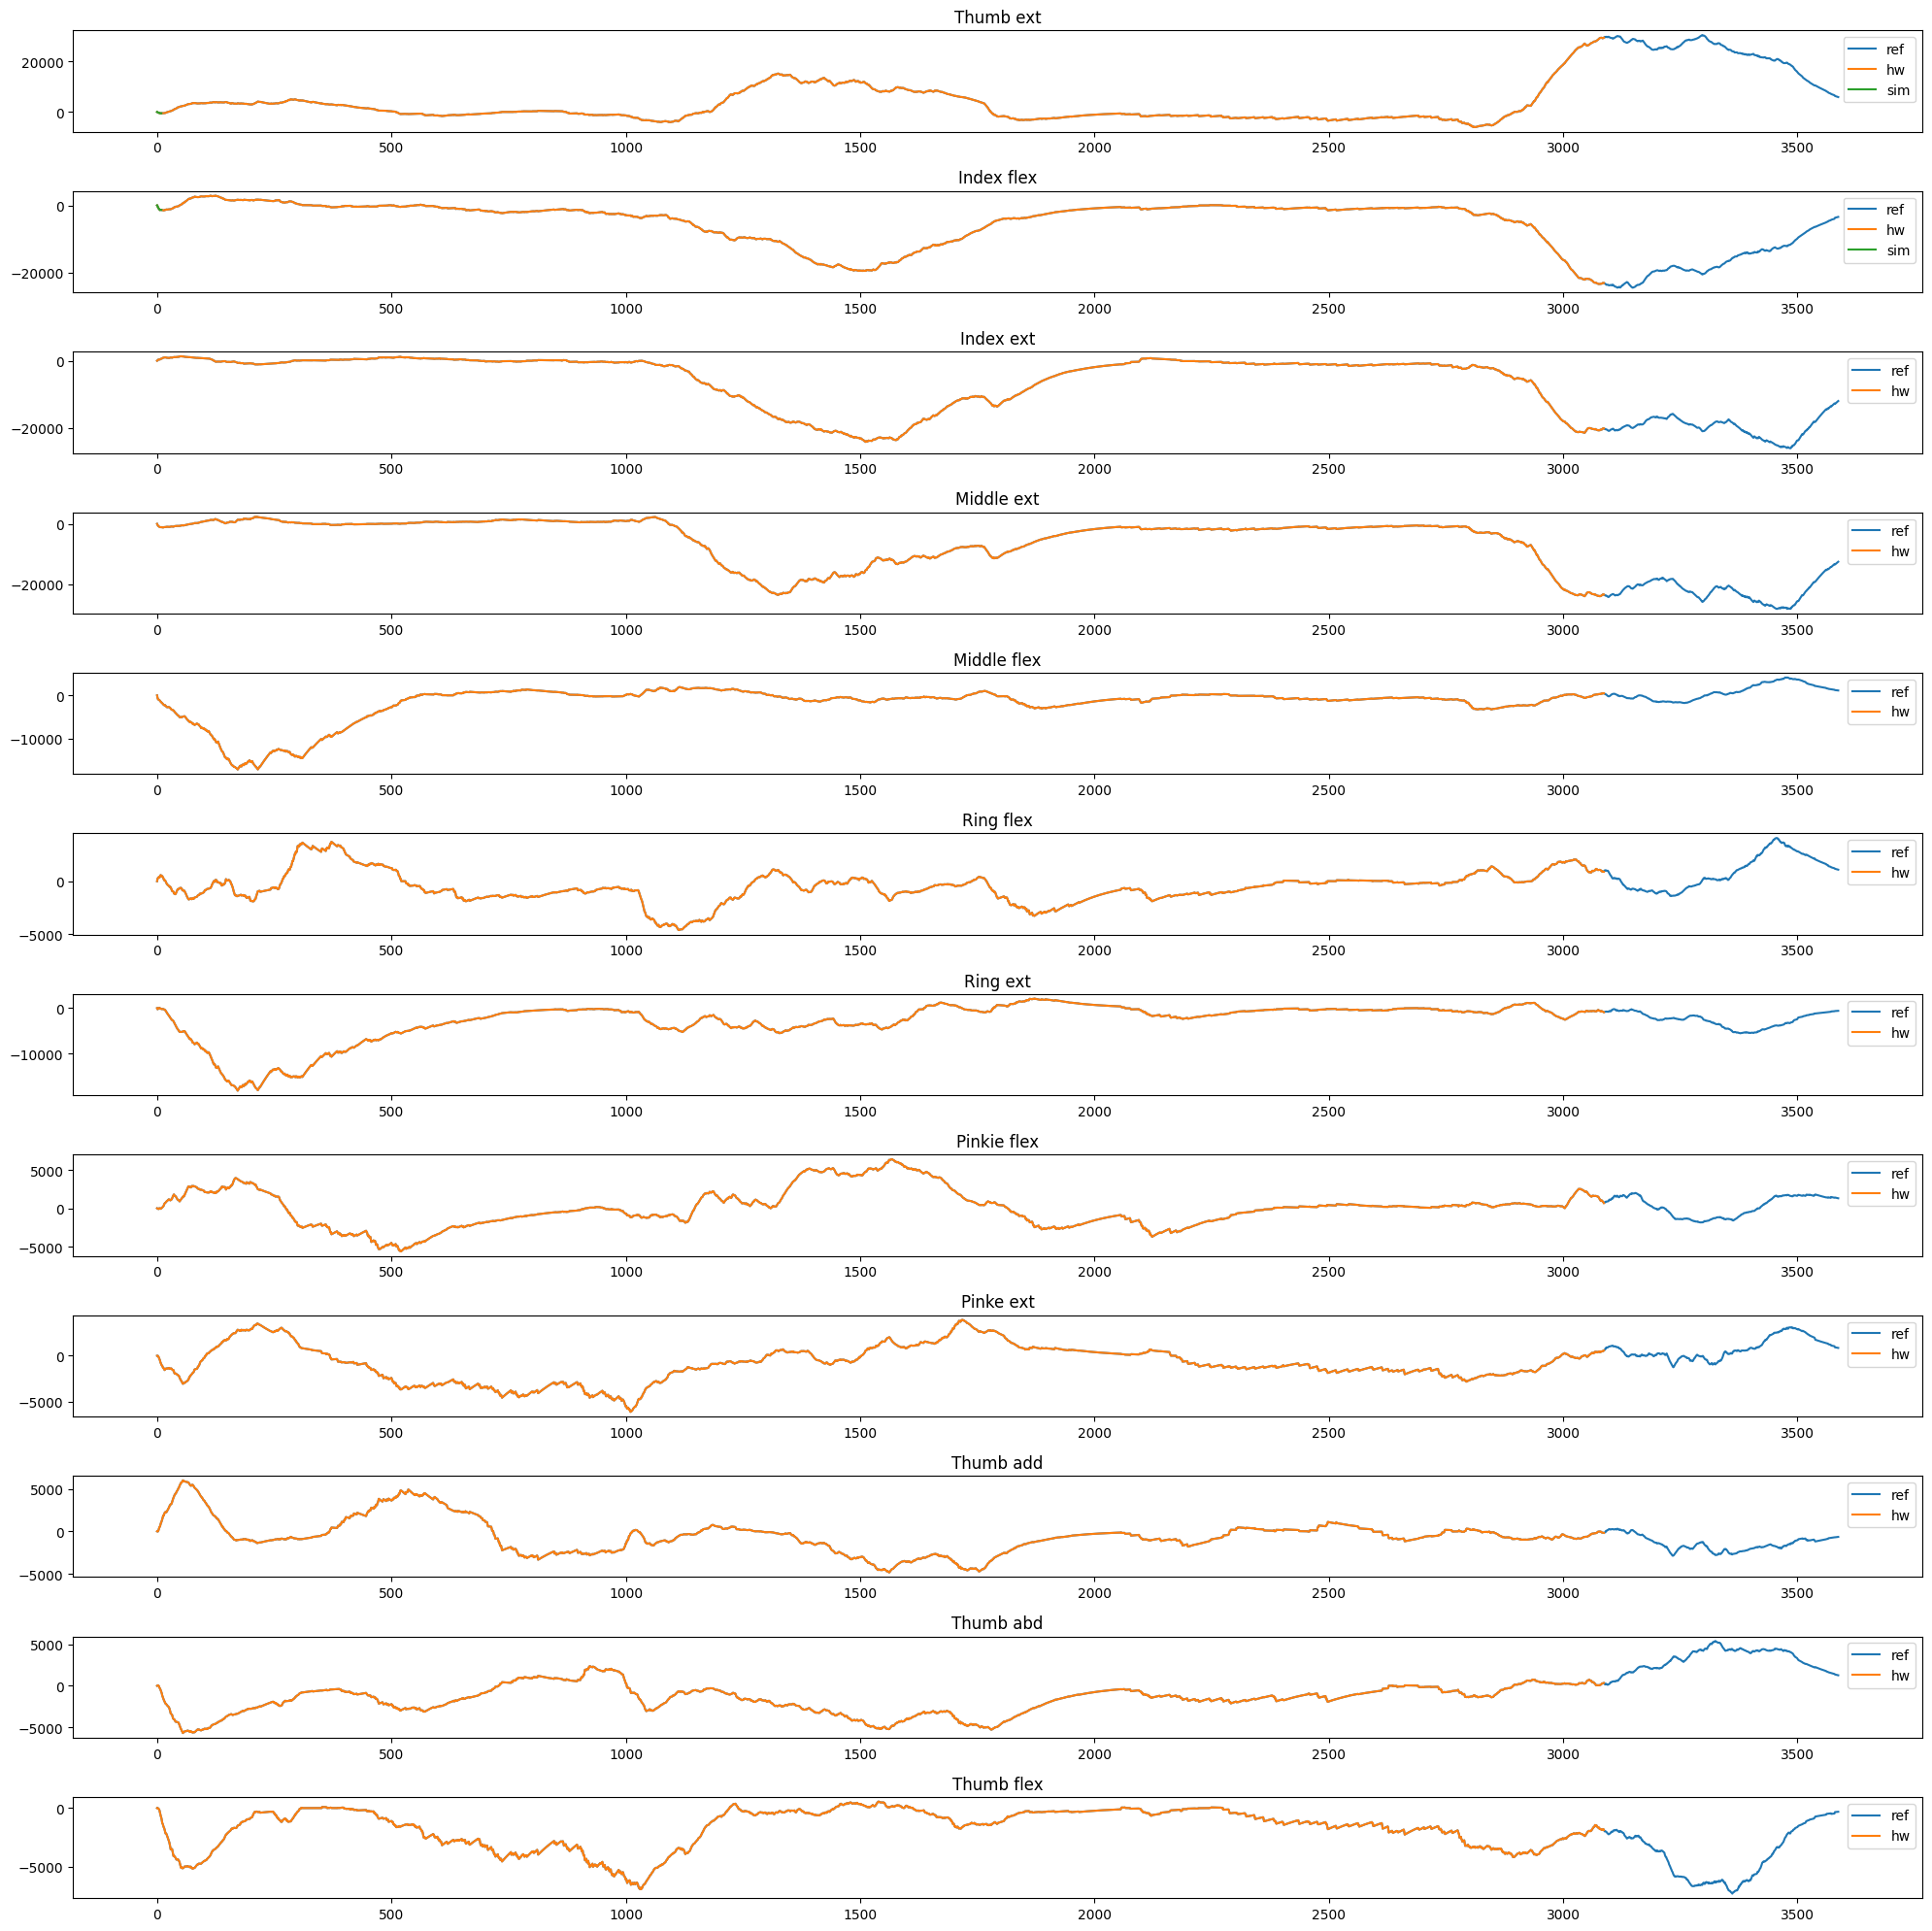

In [67]:
#@title Plot Ground Truth, simulation results, hardware results

fig, axs = plt.subplots(12, 1, figsize=(20, 20))
titles = ['Index flex','Index ext','Middle ext','Middle flex','Ring flex','Ring ext','Pinkie flex','Pinke ext','Thumb add','Thumb abd','Thumb flex','Thumb ext']
stop = min(20000,hardware.shape[0]+500)
for k, ax in enumerate(axs.flatten(), start=0):
    ax.plot(voltage_4[3:3+stop,k],label='ref')
    ax.plot(hardware[0:stop,k],label='hw')
    if(k<2):
      ax.plot(sim[:,k],label='sim')
    ax.legend()
    ax.set_title(f'{titles[k-1]}')

plt.tight_layout()
plt.show()